## Problem Statement

1. Detect episodes of usage within the sample of data provided, with start and stop timestamps.

2. Show the original data with the usage episodes marked for easy comparison.

3. Documentation regarding algorithms, data prep steps, and transformations to solve 1 & 2. Describe any problems encountered or stumbling blocks in this kind of analysis.

## Setup

In [51]:
rm(list=ls())
options(warn=-1)

### Load libraries

In [52]:
library(dplyr) # data manipulation
library(tidyr) # reshaping data
library(ggplot2) # visualizations
library(gridExtra) # arranging visualizations
library(lubridate) # working with date-time
library(readr) # reading/writing data
library(zoo) # working with time-series data
library(forecast) # useful time-series analytics
library(infer) # applying statistical inference
library(factoextra) # easily applying kmeans elbow method plotting

### Read and View the Data

In [53]:
df = readr::read_csv("data-sample.csv")

head(df)

Parsed with column specification:
cols(
  timestamp = col_character(),
  power = col_double()
)



timestamp,power
<chr>,<dbl>
2019-06-14 00:00:00 EDT,27.41
2019-06-14 00:01:00 EDT,27.40
2019-06-14 00:02:00 EDT,27.42
2019-06-14 00:03:00 EDT,27.42
2019-06-14 00:04:00 EDT,27.42
2019-06-14 00:05:00 EDT,27.43


One of the first things I noticed is that the timestamps have been read in as a character vector. Let's change that to the appropriate data type.

In [54]:
df = df %>%
  mutate(timestamp = ymd_hms(timestamp, tz = "US/Eastern"))

head(df)

timestamp,power
<dttm>,<dbl>
2019-06-14 00:00:00,27.41
2019-06-14 00:01:00,27.40
2019-06-14 00:02:00,27.42
2019-06-14 00:03:00,27.42
2019-06-14 00:04:00,27.42
2019-06-14 00:05:00,27.43


Now that our data is in the right format, let's move onto some EDA (Exploratory Data Analysis).

## Exploration

### Visualizing the Data

First we will visualize the data to get a clear picture of what we're working with

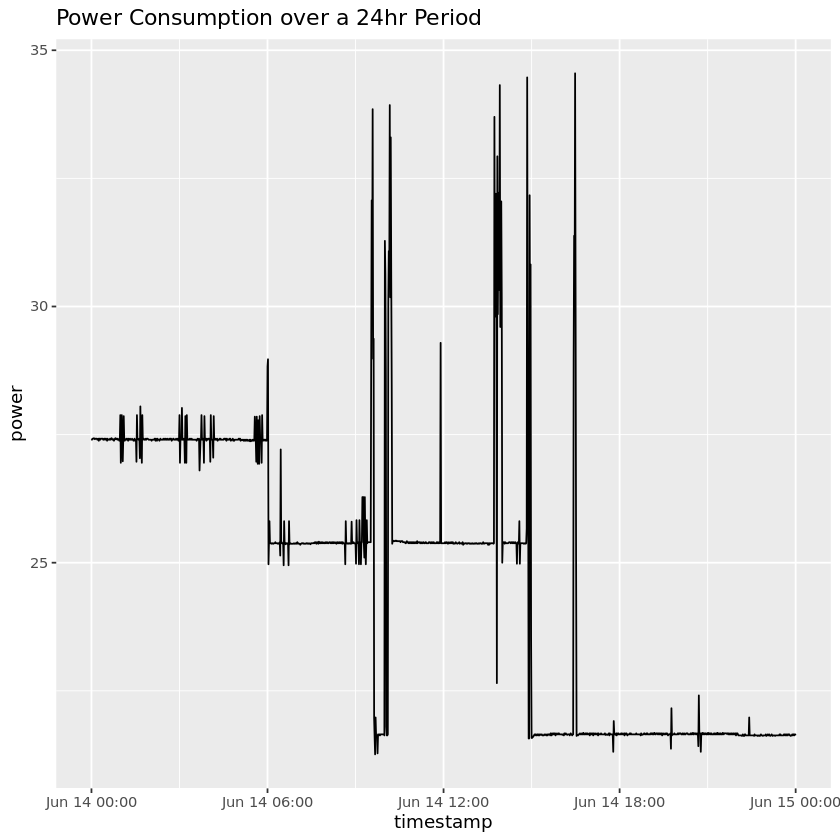

In [55]:
df %>%
  ggplot(aes(x = timestamp, y = power)) +
  geom_line() +
  ggtitle("Power Consumption over a 24hr Period")

As mentioned in the exercise, we can see that the power stabilizes at 3 different levels. These "stable" periods are referred to as idle/background consumption. In addition to idle consumption, there also seem to be 2 other features that appear:

1. Small spikes/noise of about +/- 1 watt

  - This could be valid usage, or could also be heavier noise occurring during idle consumption
  
2. Large spikes varying about 10-12 watts

  - These look like valid usage episodes
  
### Assumptions

Now that I have had the opportunit to briefly look at the data, I'm going to make some assumptions before moving forward.

1. The data is a **representative sample** of the population.

2. The small spikes are noise in idle consumption.

3. The large spikes are **valid** usage episodes and what should be targeted for detection.

### Describing the Data

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



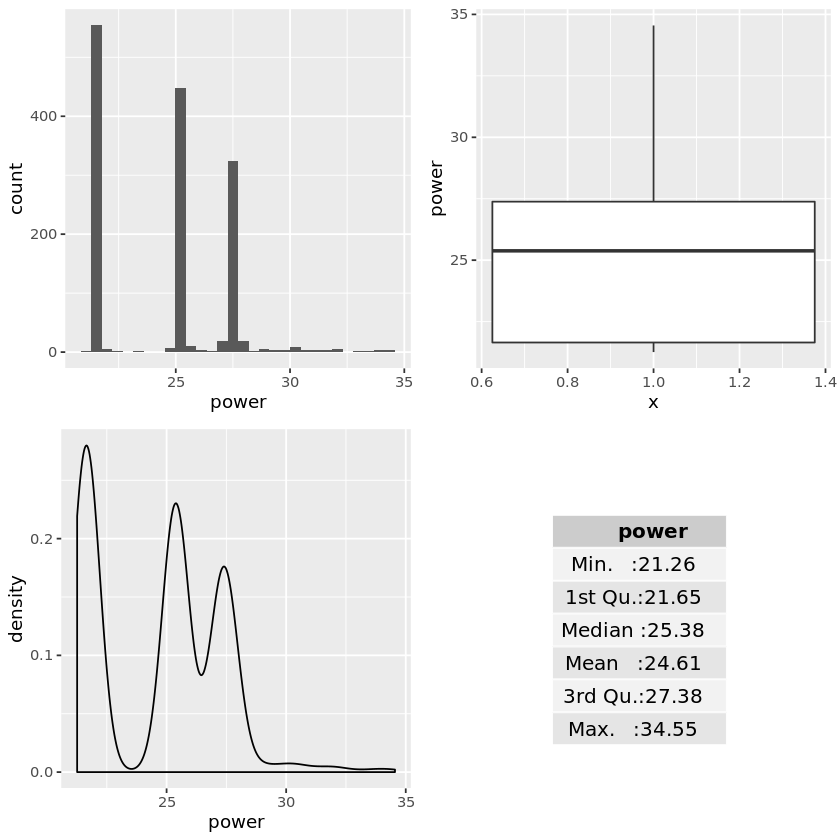

In [56]:
hist = df %>%
  ggplot(aes(power)) +
  geom_histogram()

dens = df %>%
  ggplot(aes(power)) +
  geom_density()

box = df %>%
  ggplot(aes(x = 1, y = power)) +
  geom_boxplot()

summ = summary(df %>% select(-timestamp))

grid.arrange(hist, box, dens, tableGrob(summ), nrow = 2)

As expected, the histogram and density plots show the shape of the data where the data clusters at the 3 different levels that the idle consumption bounces to. What is a bit unexpected, though, is how no outliers are showing up in the boxplot. I have a hunch that if we look at the spread of data in hourly windows, we would start to see outliers appear. Let's quickly see.

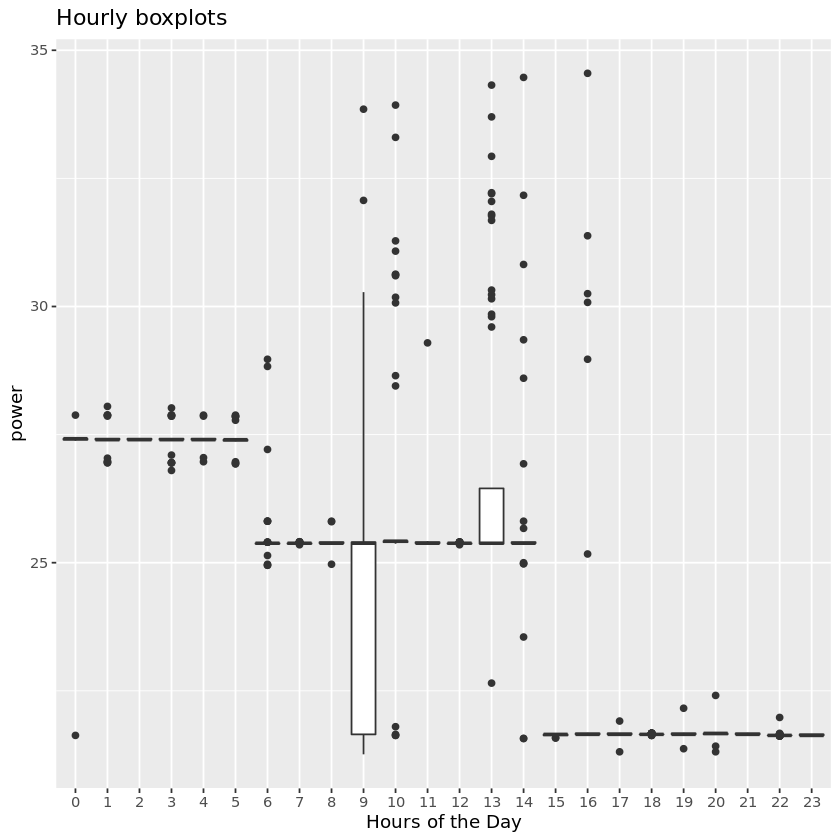

In [57]:
# Parse the timestamps
df_broken = df %>%
  mutate_at(vars(timestamp), funs(year, month, day, hour))

df_broken %>%
  ggplot(aes(x = as.factor(hour), y = power)) +
  geom_boxplot() +
  xlab("Hours of the Day") +
  ggtitle("Hourly boxplots")

Now this definitely helps a bit more. We can clearly see the idle consumption levels, and also varying ranges of outliers. This is particularly useful for testing statistical significance.

### Transforming the Data

We can see a clear downward trend of the idle consumption (and overall data) over time which could make detection a bit more complex. However, we can transform the data by differencing it to see if this makes the data more stationary and removes the trend

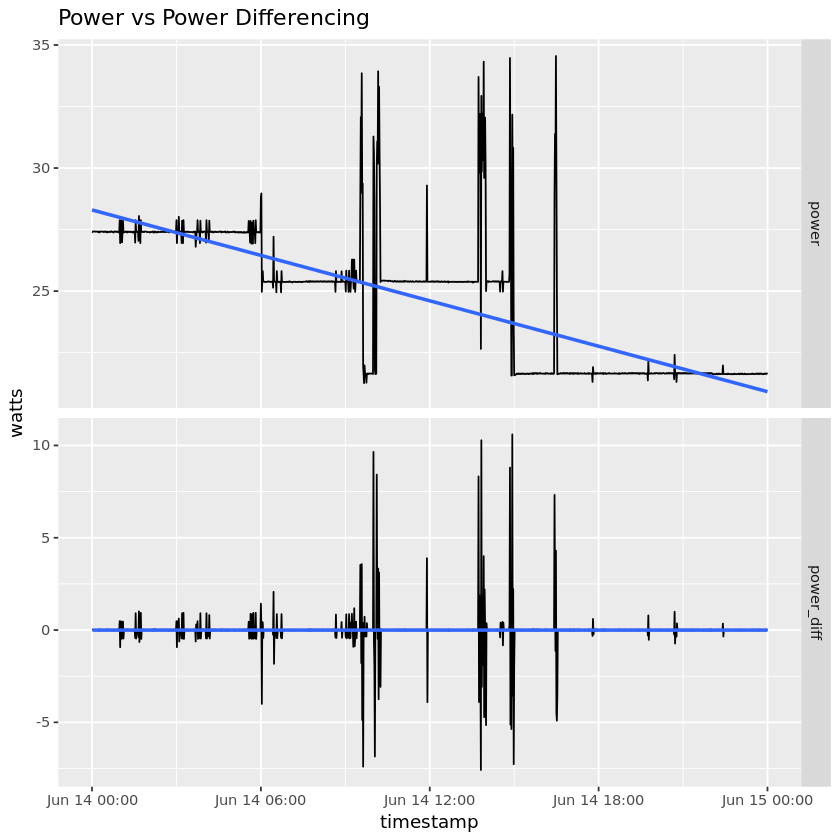

In [58]:
df_diff = df %>%
  mutate(power_diff = power - lag(power))

df_diff %>%
  gather("key", "value", -timestamp) %>%
  ggplot(aes(x = timestamp, y = value)) +
  geom_line() +
  geom_smooth(method = "lm", se = FALSE) +
  facet_grid(key~., scales = "free") +
  ylab("watts") +
  ggtitle("Power vs Power Differencing")

Power differenced is much more stable, and will prove much easier to work with. Let's re-do the histogram.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



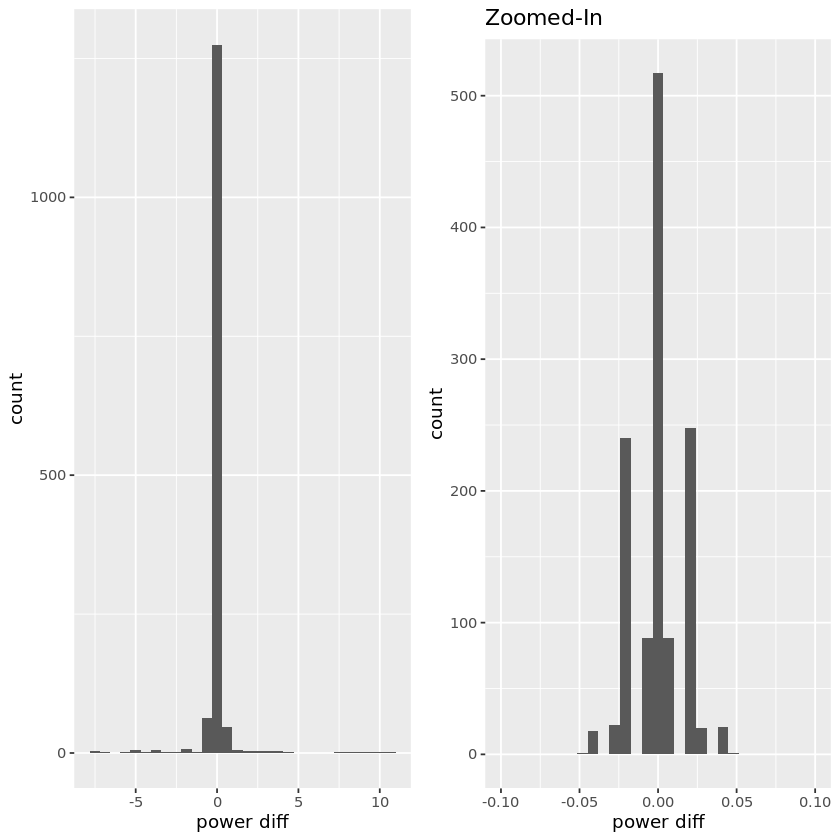

In [59]:
p1 = df_diff %>%
  ggplot(aes(power_diff)) +
  geom_histogram() +
  xlab("power diff")

p2 = df_diff %>%
  ggplot(aes(power_diff)) +
  geom_histogram() +
  xlim(c(-0.1,0.1)) +
  xlab("power diff") +
  ggtitle("Zoomed-In")
  

grid.arrange(p1, p2, nrow = 1)

We can see the differenced background noise consumption (tall peak) is pretty symmetrical (shown better in the plot to the right) and that it fluctuates within about +/- 0.25 of its previous value at times.

This is a **VERY** Leptokurtic distribution. It's almost uniform. While this could pose some challenges for different statistical techniques, we will carry forward nonetheless to see if that is the case as the data is much more "normal-like" than prior to differencing.

Now that our data is more "normal-like", we can attempt to describe it with some stats. Namely the 2 that would describe it best are:

1. The mean for its central tendency

2. The standard deviation for its spread

Instead of getting these values straight-up, we can potentially get more value out of how they change over time. To do this I'll use an hour long window that will roll every minute over the **Power Difference** collecting the *mean* and *standard deviation*.

At this point I am also going to transform the Power Difference by taking the absolute value of it. If we refer back to the 3rd assumption, that we are to detect the large spikes, then if a large spike up would denote the start of a usage period, a large spike down would mean the end of the period. For this analysis, I'm only going to be concerned with the magnitude of the change. (It's possible that direction could be useful if used correctly)

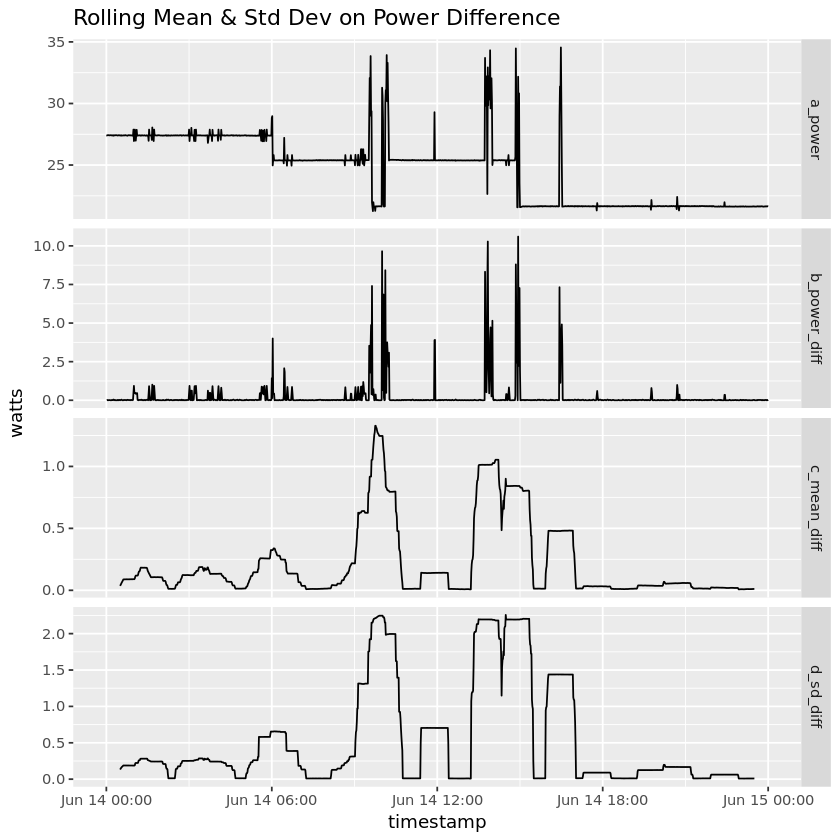

In [60]:
# Convert power difference to absolute value
df_diff$power_diff = abs(df_diff$power_diff)

# Convert data to time-series object
df_diff_ts = zoo(df_diff$power_diff, order.by = df_diff$timestamp)

# Calculate rollilng stats
df_diff$mean_diff = rollapply(df_diff_ts, width = 60, FUN = mean, fill = NA)
df_diff$sd_diff = rollapply(df_diff_ts, width = 60, FUN = sd, fill = NA)

# Renaming the variable names for ordering of plot and turning the mean_diff and sd_diff back to numeric data types
df_diff = df_diff %>%
  mutate_at(vars(mean_diff, sd_diff), as.numeric)
  

df_diff %>%
  rename(
    "a_power"=power,
    "b_power_diff"=power_diff,
    "c_mean_diff"=mean_diff,
    "d_sd_diff"=sd_diff
  ) %>%
  gather("key", "value", -timestamp) %>%
  ggplot(aes(x = timestamp, y = value)) +
  geom_line() +
  facet_grid(key~., scales = "free") +
  ylab("watts") +
  ggtitle("Rolling Mean & Std Dev on Power Difference")

## Detecting Usage

Now that we have several different views of our data, let's look to see if we can use them to detect when usage occurs. I think setting thresholds is a logical & simple first step to seeing if it can get the job done.

### Setting Thresholds Using Inferential Statistics

Going back to our assumption #1 that the data is a **representative sample**, we can use it to infer what the mean and standard deviation of the population could be. This is performed by repeatedly sampling the data *with replacement*, calculating a stat across each bootsrap, and forming the *Null Distribution*. From there we can put confidence intervals around and use the intervals as our thresholds.

In [61]:
# Get overall stats of absolute power difference
overall_stats = df_diff %>%
  summarise(mean = mean(power_diff, na.rm = TRUE),
            sd = sd(power_diff, na.rm = TRUE))

mean_diff_overall = overall_stats %>% pull(mean)
sd_diff_overall = overall_stats %>% pull(sd)

# Create null distributions
mean_diff_null_distn = df_diff %>%
  specify(response = power_diff) %>%
  hypothesize(null = "point", mu = mean_diff_overall) %>%
  generate(reps = 1000, type = "bootstrap") %>%
  calculate(stat = "mean")

sd_diff_null_distn = df_diff %>%
  specify(response = power_diff) %>%
  hypothesize(null = "point", sigma = sd_diff_overall) %>%
  generate(reps = 1000, type = "bootstrap") %>%
  calculate(stat = "sd")

# Get confidence intervals - use 97.5% as we are only concerned with values that are significantly larger
ci_mean = mean_diff_null_distn %>% get_ci() %>% pull(`97.5%`)
ci_sd = sd_diff_null_distn %>% get_ci() %>% pull(`97.5%`)

Now that we have our thresholds let's apply them and see how we did.

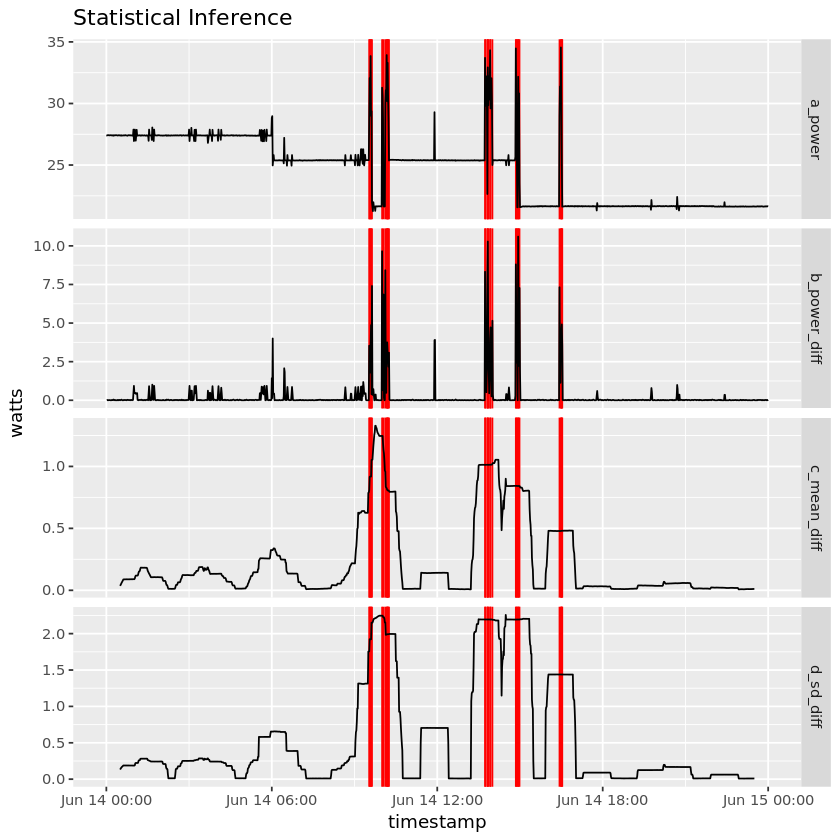

In [62]:
df_diff_usage = df_diff %>%
  mutate(usage = ifelse((power_diff > 2.5 & mean_diff > ci_mean & sd_diff > ci_sd), TRUE, FALSE))

df_diff_usage %>%
  rename(
    "a_power"=power,
    "b_power_diff"=power_diff,
    "c_mean_diff"=mean_diff,
    "d_sd_diff"=sd_diff
  ) %>%
  gather("key", "value", -timestamp, -usage) %>%
  ggplot(aes(x = timestamp, y = value)) +
  geom_vline(xintercept = df_diff_usage$timestamp[which(df_diff_usage$usage)], color = "red") +
  geom_line() +
  facet_grid(key ~ ., scales = "free") +
  ylab("watts") +
  ggtitle("Statistical Inference")

In [63]:
start = c()
end = c()

df_diff_usage$usage[1] = FALSE

for(i in 2:(nrow(df_diff_usage) - 1)) {
  if(df_diff_usage$usage[i]) {
    if((df_diff_usage$usage[i-1] == TRUE & df_diff_usage$usage[i+1] == TRUE)) {
      next
    } else if ((df_diff_usage$usage[i-1] == FALSE & df_diff_usage$usage[i+1] == TRUE)) {
      start[[i]] = df_diff_usage$timestamp[i]
    } else if ((df_diff_usage$usage[i-1] == TRUE & df_diff_usage$usage[i+1] == FALSE)) {
      end[[i]] = df_diff_usage$timestamp[i]
    } else {
      start[[i]] = df_diff_usage$timestamp[i]
      end[[i]] = df_diff_usage$timestamp[i]
    }
      
  } else {
    next
  }
}

start = as_datetime(start[complete.cases(start)], tz = "US/Eastern")
end = as_datetime(end[complete.cases(end)], tz = "US/Eastern")

final_df = data.frame(start = start, end = end) %>%
  mutate(usage_length = end - start,
         usage_length = ifelse(usage_length == 0, "<60 secs", usage_length))

final_df

start,end,usage_length
<dttm>,<dttm>,<chr>
2019-06-14 09:32:00,2019-06-14 09:33:00,60
2019-06-14 09:35:00,2019-06-14 09:36:00,60
2019-06-14 09:38:00,2019-06-14 09:38:00,<60 secs
2019-06-14 10:00:00,2019-06-14 10:00:00,<60 secs
2019-06-14 10:03:00,2019-06-14 10:03:00,<60 secs
2019-06-14 10:07:00,2019-06-14 10:07:00,<60 secs
2019-06-14 10:10:00,2019-06-14 10:13:00,180
2019-06-14 10:15:00,2019-06-14 10:15:00,<60 secs
2019-06-14 13:44:00,2019-06-14 13:45:00,60


### Using Unsupervised Learning

I feel that the above is a sound method for this exercise, however, I am curious to see how an algorithm like KMeans could perform against this data. I will let it cluster the data against the transformations I created, i.e power_diff, mean_diff, and sd_diff.

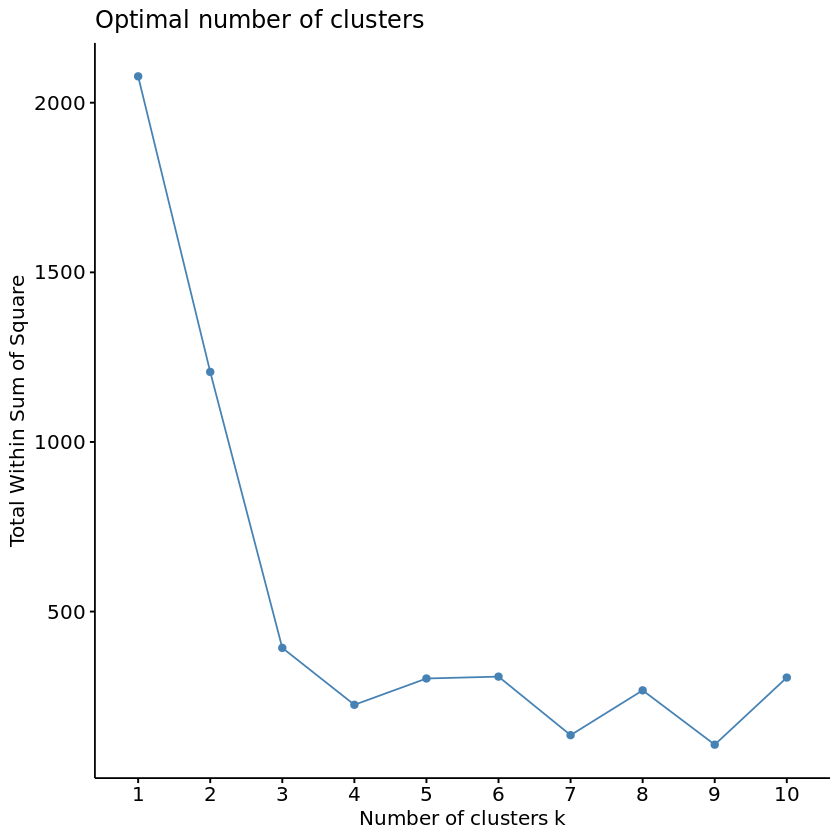

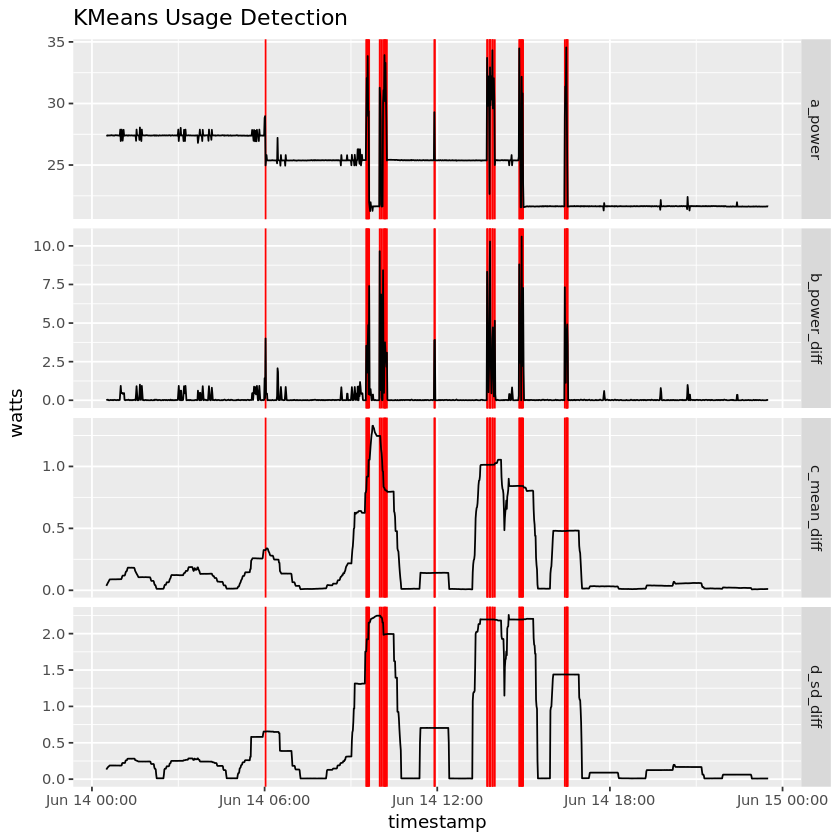

In [64]:
df_km_usage = df_diff %>%
  filter(!is.na(mean_diff),
         !is.na(sd_diff))

set.seed(0415)

# Find optimal number of clusters using the elbow method
fviz_nbclust(df_km_usage %>% select(-timestamp, -power), kmeans, method = "wss")

real_k = kmeans(df_km_usage %>% select(-timestamp, -power), centers = 3)
df_km_usage$cluster = real_k$cluster

df_km_usage %>%
  rename(
    "a_power"=power,
    "b_power_diff"=power_diff,
    "c_mean_diff"=mean_diff,
    "d_sd_diff"=sd_diff
    # "e_usage"=usage
  ) %>%
  gather("key", "value", -timestamp, -cluster) %>%
  ggplot(aes(x=timestamp, y = value)) +
  geom_vline(xintercept = df_km_usage$timestamp[df_km_usage$cluster == 2], col = "red") +
  geom_line() +
  facet_grid(key~., scales="free") +
  ylab("watts") +
  ggtitle("KMeans Usage Detection")

In [65]:
df_km_us = df_km_usage %>%
  mutate(usage = ifelse(cluster == 2, TRUE, FALSE))

start_k = c()
end_k = c()

for(i in 2:(nrow(df_km_us) - 1)) {
  if(df_km_us$usage[i]) {
    
    if((df_km_us$usage[i-1] == TRUE & df_km_us$usage[i+1] == TRUE)) {
      next
    }
    else if ((df_km_us$usage[i-1] == FALSE & df_km_us$usage[i+1] == TRUE)) {
      start_k[[i]] = df_km_us$timestamp[i]
    } else if ((df_km_us$usage[i-1] == TRUE & df_km_us$usage[i+1] == FALSE)) {
      end_k[[i]] = df_km_us$timestamp[i]
    } else {
      start_k[[i]] = df_km_us$timestamp[i]
      end_k[[i]] = df_km_us$timestamp[i]
    }
      
  } else {
    next
  }
}

start_k = as_datetime(start_k[complete.cases(start_k)], tz = "US/Eastern")
end_k = as_datetime(end_k[complete.cases(end_k)], tz = "US/Eastern")

final_df_k = data.frame(start_k = start_k, end_k = end_k) %>%
  mutate(usage_length_k = end_k - start_k,
         usage_length_k = ifelse(usage_length_k == 0, "<60 secs", usage_length_k))

final_df_k

start_k,end_k,usage_length_k
<dttm>,<dttm>,<chr>
2019-06-14 06:02:00,2019-06-14 06:02:00,<60 secs
2019-06-14 09:32:00,2019-06-14 09:33:00,60
2019-06-14 09:35:00,2019-06-14 09:36:00,60
2019-06-14 09:38:00,2019-06-14 09:38:00,<60 secs
2019-06-14 10:00:00,2019-06-14 10:00:00,<60 secs
2019-06-14 10:03:00,2019-06-14 10:03:00,<60 secs
2019-06-14 10:07:00,2019-06-14 10:07:00,<60 secs
2019-06-14 10:10:00,2019-06-14 10:12:00,120
2019-06-14 10:15:00,2019-06-14 10:15:00,<60 secs


## Conclusion

### Methodology Decision

I think that both methods worked pretty well with the data. I believe there are pros and cons to both as far as I can see.

I feel as though using statistical inference allows for more flexibility from a tuning perspective since you can tweak the thresholds, etc. However, at the same time that is a manual process that would need to be monitored/revisited.

With KMeans, the opposite is somewhat true. There's less threshold tweaking involved, and more hyperparameter tuning to find which combinations optimally detect usage.

If I had to choose which one I think did better in this exercise (w/o knowing the right answer) I would choose the **KMeans** algorithm. While both methods captured the large spikes, there were some other medium-sized spikes that occurred in the data that seemd as though they could have been valid usage, and KMeans picked them up. These occurred at ~ 6am and ~12pm.

### Problems/Difficulties/Areas for Improvement

1. More Data

  - I think this is a no-brainer, but is often times the case. The more data (particularly "normal/healthy" data) that can be collected the better. This would allow us to rely less on assumptions. In addition to just more records, including other variables I think could help. For example: ambient readings of the environment, location of the equipment, etc.

2. Transforming for High Kurtosis

  - For me this is more of an *Area for Improvement*. After differencing the data, I pointed out that the distribution was Leptokurtic. If there's a way to tranform that into more of a normal distriubution, I think it would have lead to slightly better detection. While I think both methods did good, they seemed a little tight/under-sensitive; i.e the start date is a little late, and the end date is a little early.